In [466]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, FermiDirac
from gpaw import restart

# Size of the unit cell (Ångstrom)
a = 8.0

# Defining a single H atom at the corner of the cell.
atoms = Atoms('H', positions=[(0,0,0)], cell=(a, a, a))

# Defining a GPAW planewave calculator.
calc = GPAW(mode=PW(750),
            xc='PBE',
            txt=None
            )

# Setting the calculator for the atoms and converging the ground-state electron density.
atoms.calc = calc
atoms.get_potential_energy();

In [467]:
from gpaw.utilities.ps2ae import PS2AE
from ase.units import Bohr

# Function for converting the pseudo electron density into the all-electron density on a given fine grid.
h = 0.02
t = PS2AE(calc, grid_spacing=h)

# Smearing width for the nuclear potential; chosen to match the grid.
smear = h * Bohr

# Function for getting the full electrostatic potential; the sign is flipped to match the IAM and exact potential.
ps2ae = -t.get_electrostatic_potential(rcgauss=smear)

# Choosing a radial line passing through the nucleus for 1D plotting; zero level is normalized.
dftpot = ps2ae[0,0]
dftpot -= dftpot.min()

In [468]:
from abtem.parametrizations import kirkland, load_kirkland_parameters
from abtem.potentials import kappa

# Parameterized potential by Kirkland.
parameters = load_kirkland_parameters()

# Defining a position coordinate and computing the values of the potential (kappa is a conversion factor).
r = np.linspace(0, atoms.cell[0,0], ps2ae.shape[-1])
iampot = kirkland(r[:], parameters[1]) / kappa

In [469]:
from numpy import pi, exp

q = 1.602176*10**-19;
eps0 = 8.854188*10**-12;

# Exact solution of the  electrostatic potential of hydrogen converted to Ångström.
y = q / (4 * pi * eps0) * (exp(-2 * r / Bohr) / r + exp(-2 * r / Bohr) / Bohr)  * 1e10;

/var/folders/8n/_v135h7x4dl2wfy0q4r_f7kh0000gp/T/ipykernel_34308/298370068.py:7: RuntimeWarning: divide by zero encountered in true_divide
  y = q / (4 * pi * eps0) * (exp(-2 * r / Bohr) / r + exp(-2 * r / Bohr) / Bohr)  * 1e10;


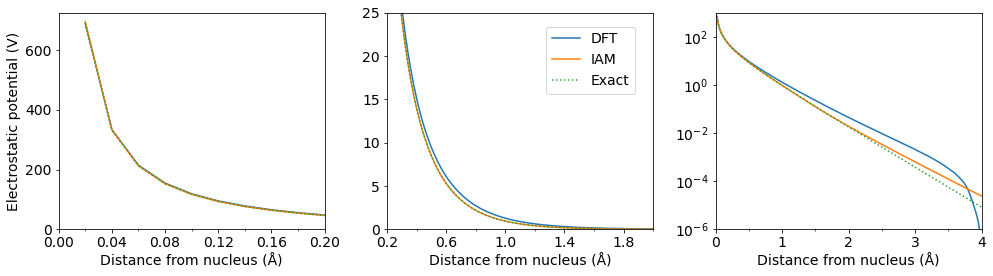

In [505]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# Plotting the comparison between the three models.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14,4))
fig.tight_layout(pad=1.6)

ax1.set_xlim((0.0,0.2));
ax1.set_ylim((0,y[1]*1.05));
ax1.plot(r[1:], dftpot[1:], label='DFT')
ax1.plot(r[1:], iampot[1:], label='IAM')
ax1.plot(r[1:], y[1:], label='Exact', linestyle=':');
ax1.set_xlabel('Distance from nucleus (Å)')
ax1.set_ylabel('Electrostatic potential (V)')
ax1.set_xticks(np.arange(0,0.24,0.04))
ax1.xaxis.set_minor_locator(MultipleLocator(0.02))

ax2.set_xlim((0.2,2.0));
ax2.set_ylim((0.0,25.0));
ax2.plot(r[1:], dftpot[1:])#, label='DFT')
ax2.plot(r[1:], iampot[1:])#, label='IAM')
ax2.plot(r[1:], y[1:], linestyle=':')#, label='Exact');
ax2.set_xlabel('Distance from nucleus (Å)')
ax2.set_xticks(np.arange(0.2,2.2,0.4))
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax3.set_xlim((0.0,4.0));
ax3.set_ylim((0.000001,1000));
ax3.plot(r[1:], dftpot[1:])#, label='DFT')
ax3.plot(r[1:], iampot[1:])#, label='IAM')
ax3.plot(r[1:], y[1:], linestyle=':')#, label='Exact');
ax3.set_yscale('log')
ax3.set_xlabel('Distance from nucleus (Å)')
ax3.xaxis.set_minor_locator(MultipleLocator(0.5))

fig.legend(loc=(0.55,0.66));
plt.rcParams['font.size'] = 14

In [506]:
fig.savefig('H_atom.pdf')